In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from os.path import join as pjoin
from scipy import signal
import scipy as sp
import os
from matplotlib.backends.backend_pdf  import PdfPages
import spirometry
import wob


In [2]:
settings = {
    "inputfolder": r'/Users/jackdunsford/Library/CloudStorage/OneDrive-Personal/GNAR/sample_data/01-101',
    
    "timecol":0,
    "flowcol":17,
    "volumecol":18,
    "poescol":13,   
    "pgascol":14,
    #enter the name of the file and the breath number you wish to exclude from the IC volume drift correction
    "ignoreic": [
        ["01-101_V3_IC160.txt", [7,9,10,11]]
    ],
    #enter the name of the file and the breath number you wish to exclude from volume drift correction and averaging
    "ignorebreath":[
        ["01-101_V3_B080.txt", [2,3,4,5]],
        ["01-101_V3_B140.txt", [1,7,8]],
        ["01-101_V3_B100.txt", [4,5,6]],
        ["01-101_V3_B120.txt", [1,2,7,8,10]]
    ],
    "saveiccorrection": True, #saves a plot with the ic trend correction to check for incorrect EELV detection
    "saverawflowvolume": True, #saves a plot of the raw flow and volume traces
    "saveflowvolumeloops": True, #saves a plot with the FV loop and MEFV for each stage
    "savewobplots": True,
    "saveoutput": True, #saves an excel of the dataframe containing data for each stage of exercise
    "savemefv": True, #saves a figure of the MEFV curve with all FVCs
    "savemefvdata": True, #saves an excel with fvc, fev1, pef, slope ratio, and data for the MEFV curve
    "saveaveragedata": True, #saves an excel with the data of the average flow volume loop for each stage
}

In [3]:
def correcttrend(volume):
        """corrects volume trend"""

        vol = volume.squeeze()
        peaks = signal.find_peaks((vol*-1), prominence=0.05, distance=0.25 * 1000)[0]
        f = sp.interpolate.interp1d(peaks, vol[peaks], 'linear', fill_value="extrapolate")
        peaksresampled = f(np.linspace(0, vol.size-1, vol.size))
        corvol = volume - peaksresampled
        
        return corvol

In [4]:
path = r'/Users/jackdunsford/Library/CloudStorage/OneDrive-Personal/GNAR/sample_data/01-101/breaths/01-101_V3_B160.txt'

df = pd.read_csv(path, 
                delimiter='\t')
time = df.iloc[:, settings['timecol']].to_numpy()
flow = df.iloc[:, settings['flowcol']].to_numpy()
volumeraw = df.iloc[:, settings['volumecol']].to_numpy()
poes = df.iloc[:, settings['poescol']].to_numpy()
pgas = df.iloc[:, settings['pgascol']].to_numpy()
pdi = pgas - poes

volumeraw = volumeraw - volumeraw[0]
volume = correcttrend(volumeraw)
endinsp_pts, _ = signal.find_peaks(volume*-1, prominence=0.3)
endexp_pts, _ = signal.find_peaks(volume, prominence=0.3)

21.938257654545453


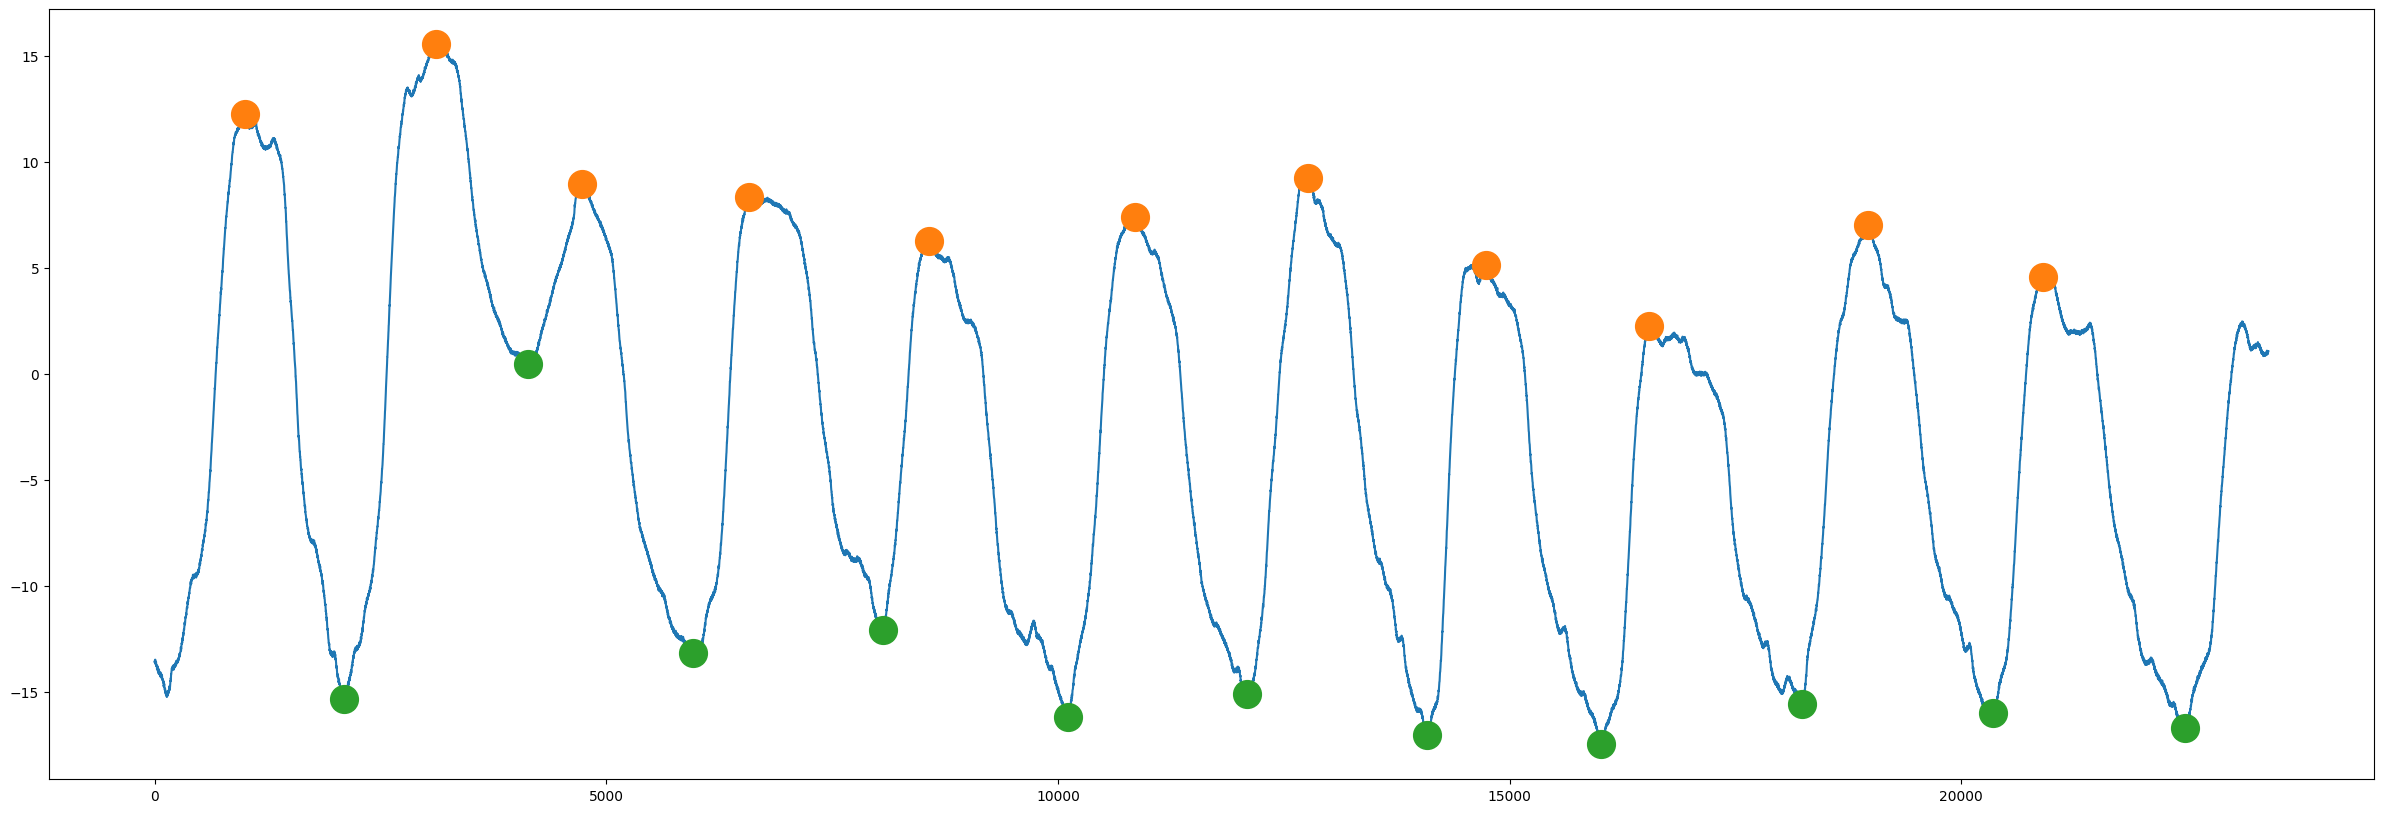

In [28]:
plt.figure(figsize=(30,10))
plt.plot(poes)
# ax2 = plt.twinx()
# ax2.plot(volume, alpha=0.5)
count=1
yl = list(plt.ylim())
# for point in endinsp_pts:
#               plt.axvline(x=point, color="grey", ls="--", lw=1)
#               if count != len(endinsp_pts):
#                   text = " #" + str(count)
#                   plt.text(point, yl[1]-((yl[1]-yl[0])*0.05), text, fontsize=8)
#                   count+=1

poes_peaks,_ = signal.find_peaks(poes, prominence=3, distance = 200)
poes_troughs,_ = signal.find_peaks(poes*-1, prominence=3, distance = 200)
# print(poes_peaks)
plt.plot(poes_peaks, poes[poes_peaks], "o", markersize=20)
plt.plot(poes_troughs, poes[poes_troughs], "o", markersize=20)

swings = []
for x in range(len(poes_peaks)):
    pswing = poes[poes_peaks[x]]-poes[poes_troughs[x]]
    swings.append(pswing)

mean_pswing = pd.Series(swings).mean()

print(mean_pswing)

np.float64(12.824484466666666)

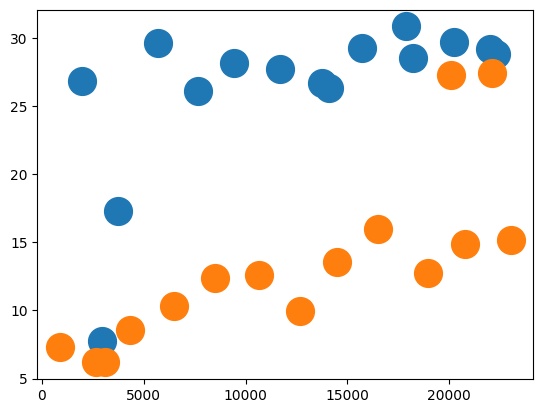

In [35]:
def pressure_swings(pressure):
    peaks,_ = signal.find_peaks(pressure, prominence=1, distance=250)
    troughs,_ = signal.find_peaks(pressure*-1, prominence=1, distance=250)
    plt.plot(peaks, pressure[peaks], "o", markersize=20)
    plt.plot(troughs, pressure[troughs], "o", markersize=20)
    swings = []
    if len(peaks) != len(troughs):
        raise Exception("Check pressure peak detection settings")
    for x in range(len(peaks)):
        pswing = pressure[peaks[x]]-pressure[troughs[x]]
        swings.append(pswing)
    mean_pswing = pd.Series(swings).mean()

    return mean_pswing

pressure_swings(pdi)


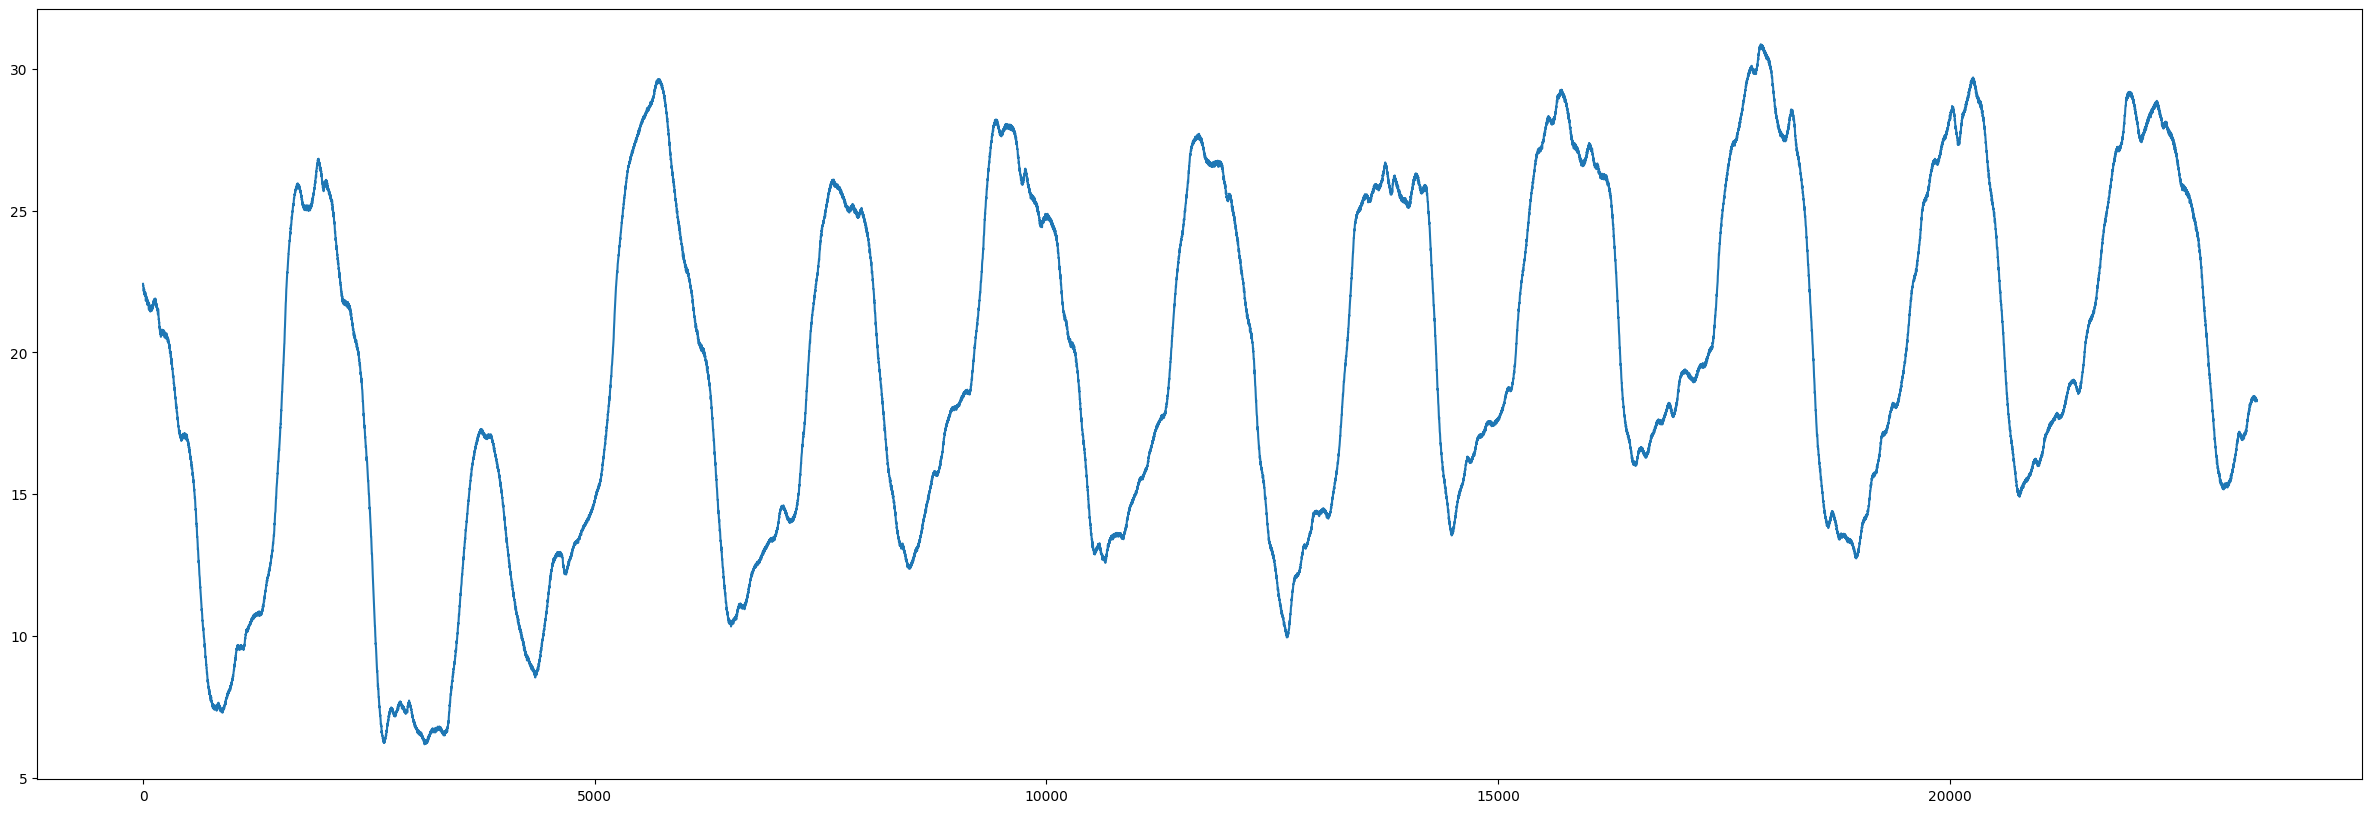

In [19]:
plt.figure(figsize=(30,10))
plt.plot(pdi)